In [ ]:
import networkx as nx
from uccgGenerator import tree_insertion
import random
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.algorithms.dag import *
from networkx.algorithms.tree.decomposition import junction_tree
from networkx.algorithms.chordal import chordal_graph_cliques

In [ ]:

label = 'I'
I_edge = 'I_edge'
F_edge = 'F_edge'
common_edge = 'common_edge'
in_current = 'in_current'

connectionstyle = 'arc3, rad=0.1'
node_size = 300
color = 'white'
font_size = 13
alpha=1
width = 2

In [ ]:
def get_IF(I, F):
    common_edges = list(set(I.edges).intersection(F.edges))
    diff_edges = list(set(I.edges).symmetric_difference(F.edges))
    IF = nx.DiGraph()

    IF.add_edges_from(common_edges+diff_edges)
    for e in set(I.edges) - set(F.edges):
        IF.edges[e][label] = I_edge
        IF.edges[e][in_current] = True
    for e in set(F.edges) - set(I.edges):
        IF.edges[e][label] = F_edge
        IF.edges[e][in_current] = False
    for e in common_edges:
        IF.edges[e][label] = common_edge
        IF.edges[e][in_current] = True
    return IF

In [ ]:
def current_graph(IF):
    current_edges = [e for e in IF.edges if IF.edges[e][in_current]]
    dg = nx.DiGraph()
    dg.add_edges_from(current_edges)
    return dg

In [ ]:
def plot_IF(IF, pos):
    color = {I_edge: 'b', F_edge: 'r', common_edge: 'k'}
    width = {True: 1.5, False: 1}
    get_color = lambda e: color[IF.edges[e][label]]
    get_width = lambda e: width[IF.edges[e][in_current]]

    nx.draw_networkx_nodes(IF, pos,
                           node_size=node_size,
                           node_color='white',
                           edgecolors='k')
    nx.draw_networkx_labels(IF, pos)
    edge_lists = [[e for e in IF.edges if IF.edges[e][in_current]],
                  [e for e in IF.edges if not IF.edges[e][in_current]]]
    alphas = [1, 0.5]
    styles = ['solid', 'dashed']
    for i in range(2):
        nx.draw_networkx_edges(IF, pos,
                           edgelist=edge_lists[i],
                           edge_color=list(map(get_color, edge_lists[i])),
                           alpha=alphas[i],
                           style=styles[i],
                           width=list(map(get_width, edge_lists[i])),
                           connectionstyle=connectionstyle)

In [109]:
def plot_complement(IF, pos):
    common_edges = [e for e in IF.edges if IF.edges[e][label] == common_edge]
    complement_edges = [e for e in IF.edges if IF.edges[e][label] != common_edge and not IF.edges[e][in_current]]
    nx.draw_networkx_edges(IF, pos, common_edges,
                           edge_color='k',
                           width=1,
                           alpha=1,
                           connectionstyle=connectionstyle)
    nx.draw_networkx_edges(IF, pos, [e for e in complement_edges if IF.edges[e][label] == I_edge],
                           edge_color='b',
                           width=1,
                           style='dashed',
                           connectionstyle=connectionstyle)
    nx.draw_networkx_edges(IF, pos, [e for e in complement_edges if IF.edges[e][label] == F_edge],
                           edge_color='r',
                           width=1,
                           style='dashed',
                           connectionstyle=connectionstyle)
    nx.draw_networkx_nodes(IF, pos,
                           linewidths=width,
                           node_size=node_size,
                           node_color=color,
                           edgecolors='k')
    nx.draw_networkx_labels(IF, pos)

In [ ]:
def flippable(IF, u, v):
    for w in IF.neighbors(u):
        if IF.edges[(u, w)][in_current] and (w, v) \
                in IF.edges and IF.edges[(w, v)][in_current]:
            return False
    return True

In [ ]:
def get_flippable_edges(IF, root):
    return [e for e in IF.subgraph(root).edges if IF.edges[e][in_current] and IF.edges[e][label] == I_edge and flippable(IF, *e)]

In [ ]:
def plot_rt(g, cycles=None):
    plt.axis('off')
    pos = graphviz_layout(rt, prog='dot')
    nx.draw_networkx_edges(g, pos, width=2)
    node_size = 1000
    color = 'white'
    font_size = 13
    alpha=1
    width = 2
    if not cycles:
        nx.draw_networkx_nodes(g, pos, linewidths=width, node_size=node_size, alpha=alpha, node_color=color, edgecolors='k', node_shape='s')
    else:
        node_contain_cycles = [u for u in g for c in cycles if c.issubset(u)]
        nx.draw_networkx_nodes(g, pos, nodelist=node_contain_cycles, linewidths=width, node_size=node_size, alpha=alpha, node_color=color, edgecolors='r', node_shape='s')
        nx.draw_networkx_nodes(g, pos, nodelist=g.nodes-set(node_contain_cycles), linewidths=width, node_size=node_size, alpha=alpha, node_color=color, edgecolors='k', node_shape='s')
        
    labels = {u: ','.join(map(str, list(u))) for u in g}
    nx.draw_networkx_labels(g, pos, labels, font_size=font_size)

In [ ]:
def process_clique(IF, pos, root, rt, plot=False):
    edges = get_flippable_edges(IF, root)
    while edges:
        u, v = edges[0]
        IF.edges[(u, v)][in_current] = False
        IF.edges[(v, u)][in_current] = True
        if plot:
            plt.figure(figsize=(18, 6))
            plt.subplot(1,3,1)
            plt.title(f'{root}, reverse {(u, v)}')
            plot_IF(IF, pos)
            plt.subplot(1,3,2)
            dg = nx.DiGraph()
            dg.add_edges_from([e for e in IF.edges if not IF.edges[e][in_current] or IF.edges[e][label]==common_edge])
            cycles = [set(c) for c in nx.simple_cycles(dg) if len(c)==3]
            plt.title(f"{cycles}")
            plot_complement(IF, pos)
            plt.subplot(1,3,3)
            plot_rt(rt, cycles)
        edges = get_flippable_edges(IF, root)
        if not nx.is_directed_acyclic_graph(current_graph(IF)):
            raise Exception



In [ ]:
def succeed(IF):
    for e in IF.edges:
        if IF.edges[e][label] == I_edge and IF.edges[e][in_current]:
            return False
        if IF.edges[e][label] == F_edge and not IF.edges[e][in_current]:
            return False
    return True

In [ ]:
def process(IF, pos, rt, root, plot=False):
    children = list(rt.successors(root))
    process_clique(IF, pos, root, rt, plot)
    if children:
        for child in children:
            process(IF, pos, rt, child, plot)
        process_clique(IF, pos, root, rt, plot)

In [ ]:
def resample(g, cycles):
    edges_to_resample = set()
    for a, b, c in cycles:
        edges_to_resample.update([(a, b), (b, c), (c, a)])
    for x, y in edges_to_resample:
        flag = random.randint(0, 1)
        if flag == 0:
            continue
        g.remove_edge(x, y)
        g.add_edge(y, x)

In [ ]:
def gen_random_acyclic_orientation(g):
    dg = nx.DiGraph()
    for u, v in g.edges:
        coin = random.randint(0, 1)
        if coin == 0:
            dg.add_edge(u, v)
        else:
            dg.add_edge(v, u)
    while not is_directed_acyclic_graph(dg):
        cycles = [c for c in nx.simple_cycles(dg) if len(c)==3]
        resample(dg, cycles)
    return dg

In [102]:

def process_clique_manually(IF, pos, plot=False):
    F = nx.DiGraph()
    F.add_edges_from([e for e in IF.edges if IF.edges[e][label] != I_edge])
    while len(F) > 0:
        source = [u for u in F if F.in_degree(u) == 0][0]
        sub = nx.DiGraph(current_graph(IF).subgraph(F.neighbors(source)))
        while len(sub):
            sink = [u for u in sub if sub.out_degree(u) == 0][0]
            if (sink, source) in current_graph(IF).edges:
                IF.edges[(sink, source)][in_current] =  False
                IF.edges[(source, sink)][in_current] = True
                assert nx.is_directed_acyclic_graph(current_graph(IF))
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plot_IF(IF, pos)
                plt.title(f'source {source}, flip {(sink, source)}')
                plt.subplot(1, 2, 2)
                dg = nx.DiGraph()
                dg.add_edges_from([e for e in IF.edges if not IF.edges[e][in_current] or IF.edges[e][label]==common_edge])
                cycles = [set(c) for c in nx.simple_cycles(dg) if len(c)==3]
                plt.title(f"{cycles}")
                plot_complement(IF, pos)
            sub.remove_node(sink)
        F.remove_node(source)

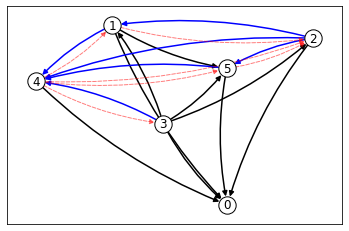

In [103]:
n, m = 10, 15
g = tree_insertion(n, m)
g = nx.complete_graph(6)
I = gen_random_acyclic_orientation(g)
F = gen_random_acyclic_orientation(g)
IF = get_IF(I, F)
pos = graphviz_layout(g, prog='dot')
pos = nx.spring_layout(IF)
plot_IF(IF, pos)

True

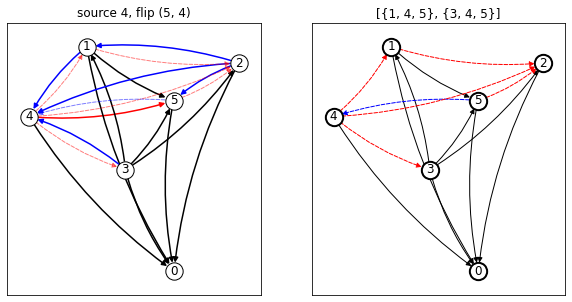

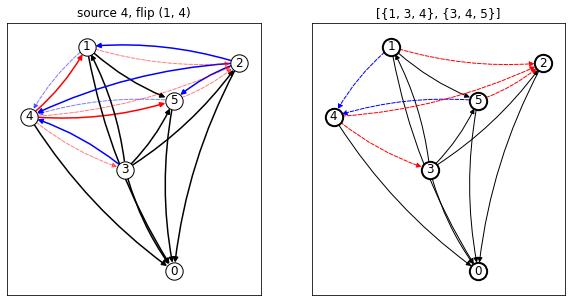

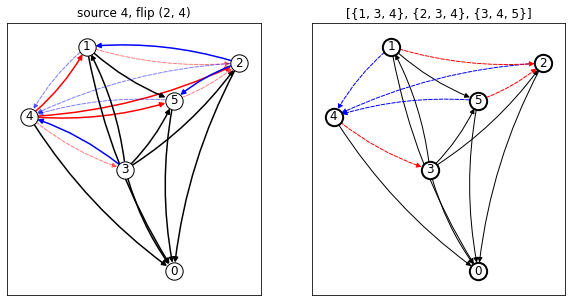

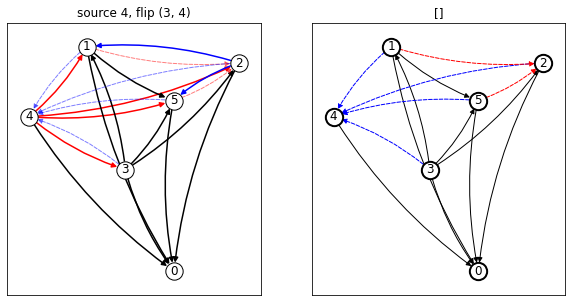

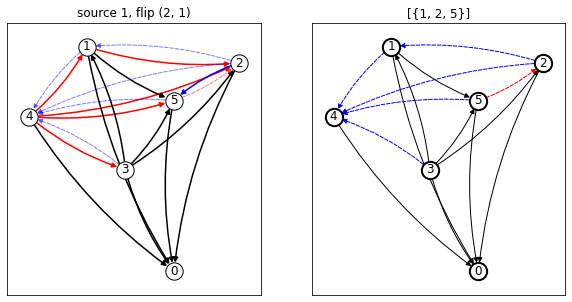

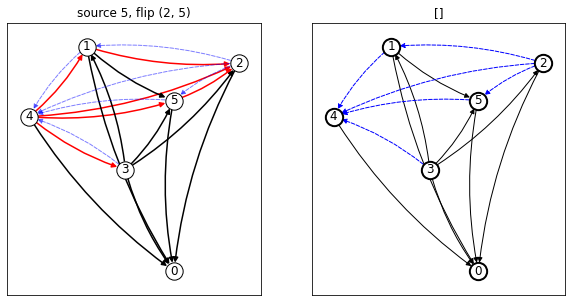

In [110]:
IF_copy = nx.DiGraph(IF)
process_clique_manually(IF_copy, pos)
succeed(IF_copy)

In [ ]:
t = junction_tree(g)
cliques = chordal_graph_cliques(g)
root = random.choice([c for c in t if frozenset(c) in cliques])
rt = nx.dfs_tree(t, root)
IF_copy = nx.DiGraph(IF)
process(IF_copy, pos, rt, root, plot=True)

In [ ]:
succeed(IF_copy)
